In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# метрика відстані між кластерами
def euclid_sqr(a, b):
    distance = np.sum(np.square(a-b), axis=1)
    return distance

In [19]:
# нормалізуємо дані
def normalize(df):
    df_norm = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
    return df_norm

In [20]:
def remove_outliers(df):
    for col in df.columns:
        if df[col].unique().shape[0]<3:
            continue
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        df = df[(df[col] < q3) & (df[col] > q1)]
    return df

In [21]:
# оновлюємо приналежність точок до відповідних створених кластерів
# розраховуючи відстань до найближчого центру
def update_assignments(df, centers_df):
    i = 0
    centers_dict = dict({cl:pd.DataFrame(columns=df.columns) for cl in centers_df.index})
    while i!=df.shape[0]:
        curr = df.iloc[i,:]
        distances = euclid_sqr(curr, centers_df)
        closest = distances.idxmin()
        centers_dict[closest].loc[curr.name] = curr
        i += 1
    return centers_dict

In [22]:
# оновлюємо координати центрів кластерів
def update_centers(centers_df, centers_dict):
    for center in centers_dict:
        centers_df.loc[center] = centers_dict[center].mean(axis=0)
    return centers_df

In [23]:
# розрахунок внутрішньокластерної відстані
def intra_distance(centers_df, centers_dict):
    i = 0
    intraclusteral = pd.DataFrame(columns=['Внутрішньокластерна відстань'])
    while i!=centers_df.shape[0]:
        curr = centers_df.iloc[i,:]
        center_name = curr.name
        intraclusteral.loc[center_name] = euclid_sqr(curr, centers_dict[center_name]).mean(axis=0)
        i += 1
    return intraclusteral

In [24]:
# розрахунок міжкластерної відстані
def inter_distance(centers_df, centers_dict):
    i = 0
    interclusteral = pd.DataFrame(columns=['Кластер 1', 'Кластер 2', 'Міжкластерна відстань'])
    while i!=centers_df.shape[0]:
        curr = centers_df.iloc[i,:]
        center_name = curr.name
        for next_center in centers_dict:
            if next_center==center_name:
                continue
            dist = euclid_sqr(curr,
                              centers_dict[next_center]).mean(axis=0)
            dist_row = [center_name, next_center, dist]
            interclusteral.loc[interclusteral.shape[0]] = dist_row
        i += 1
    interclusteral = interclusteral.set_index(['Кластер 1'])
    return interclusteral

In [25]:
# безпосередньо, функція, що виконує кластеризацію к-середніх
# об’єднує етапи update_assignments() і update_centers()
def kmeans_clustering(df, k):
    centers_df = df.sample(n=k)
    centers_df_prev = pd.DataFrame(columns=df.columns, index=centers_df.index)
    while not centers_df.equals(centers_df_prev):
        centers_df_prev = centers_df.copy()
        centers_dict = update_assignments(df, centers_df)
        centers_df = update_centers(centers_df, centers_dict)
    return centers_df, centers_dict

In [26]:
# побудова результатів кластеризації у 3-х вимірному просторі ознак
def plot_clusters(centers_df, centers_dict, k, fig, pos):
    features = centers_df.columns
    ax = fig.add_subplot(int(f'13{pos}'), projection='3d', computed_zorder=False)
    ax.set_title(f"K-means clustering with {k} clusters", fontweight='bold')
    ax.set_xlabel(features[0], fontweight='bold')
    ax.set_ylabel(features[1], fontweight='bold')
    ax.set_zlabel(features[2], fontweight='bold')
    ax.view_init(20, -110)
    for center in centers_dict:
        r, g, b = np.random.rand(), np.random.rand(), np.random.rand()
        rgb_triplet = tuple((r,g,b))
        cluster = centers_dict[center]
        ax.scatter3D(cluster.iloc[:,0],
                     cluster.iloc[:,1],
                     cluster.iloc[:,2],
                     color=rgb_triplet,
                     zorder=-1,
                     label=f'cluster {center}')
        ax.scatter3D(centers_df.loc[center][0],
                     centers_df.loc[center][1],
                     centers_df.loc[center][2],
                     color=rgb_triplet, marker='D', s=30, edgecolors='black',
                     zorder=1)
    plt.legend(loc='right')
    return fig

In [27]:
# запис внутрішньо- та міжкластерних відстаней до файлів
def distances(centers_df, centers_dict, k):
    intra = intra_distance(centers_df, centers_dict).sort_index()
    intra.to_csv(f'k{k} Внутрішньокластерна.csv', sep=';', encoding='utf-8-sig')
    inter = inter_distance(centers_df, centers_dict).sort_values(by='Кластер 1')
    inter.to_csv(f'k{k} Міжкластерна.csv', sep=';', encoding='utf-8-sig')
    return intra, inter

In [28]:
# розрахунок оцінки кластеризації за методом силуету
def silhouette_score(centers_dict, intra, inter):
    new_a = intra['Внутрішньокластерна відстань']
    s = []
    for center in centers_dict:
        a = new_a.loc[center]
        temp_b = inter.groupby('Кластер 1').mean()['Міжкластерна відстань'].drop(center, axis=0).to_list()
        temp_b = np.mean(temp_b)
        s.append((a-temp_b) / max(a, temp_b))
    s = abs(np.mean(s))
    return s

In [29]:
# запис результатів кластеризації у файл у вигляді матриці класифікації
def output_classification(centers_dict, k):
    classif_mx = pd.DataFrame(columns=['Кластер']+features)
    for center in centers_dict:
        centers_dict[center]['Кластер'] = center
        classif_mx = pd.concat([classif_mx, centers_dict[center]])
    classif_mx = classif_mx.reset_index().set_index('Кластер')
    classif_mx = classif_mx.rename(columns={'index':'Спостереження'})
    classif_mx.to_csv(f'k{k} Матриця класифікації.csv', sep=';', encoding='utf-8-sig')
    return classif_mx

In [30]:
# остаточна функція, що виконує всі вищеперечислені операції
# для 3,4 та 5 кластерів за замовчуванням
def kmeans_pipeline(data, k_all=[3,4,5]):
    df = data.copy()
    df = normalize(df)
    df = remove_outliers(df)
    s_all = pd.DataFrame(columns=['Clusters N', 'Silhouette score'])
    fig = plt.figure(figsize=(12,7))
    i = 1
    for k in k_all:
        centers_df, centers_dict = kmeans_clustering(df, k)
        classif_mx = output_classification(centers_dict, k)
        intraclusteral, interclusteral = distances(centers_df, centers_dict, k)
        s_all.loc[s_all.shape[0]] = [k, silhouette_score(centers_dict, intraclusteral, interclusteral)]
        fig = plot_clusters(centers_df, centers_dict, k, fig, i)
        i += 1
    plt.tight_layout()
    plt.savefig('kmeans_results.png', facecolor='white')
    plt.show()
    display(s_all)

In [31]:
# завантаження даних
data = pd.read_csv('https://hbiostat.org/data/repo/dmd.csv', index_col=0)
features = ['ck', 'h', 'carrier']
data.index = data.index.map(str)
data = data[features]
data.head()

,ck,h,carrier
1,22.0,99.000000,0
2,29.0,94.000000,0
3,22.0,85.500000,0
4,41.0,87.296875,0
5,28.0,93.500000,0


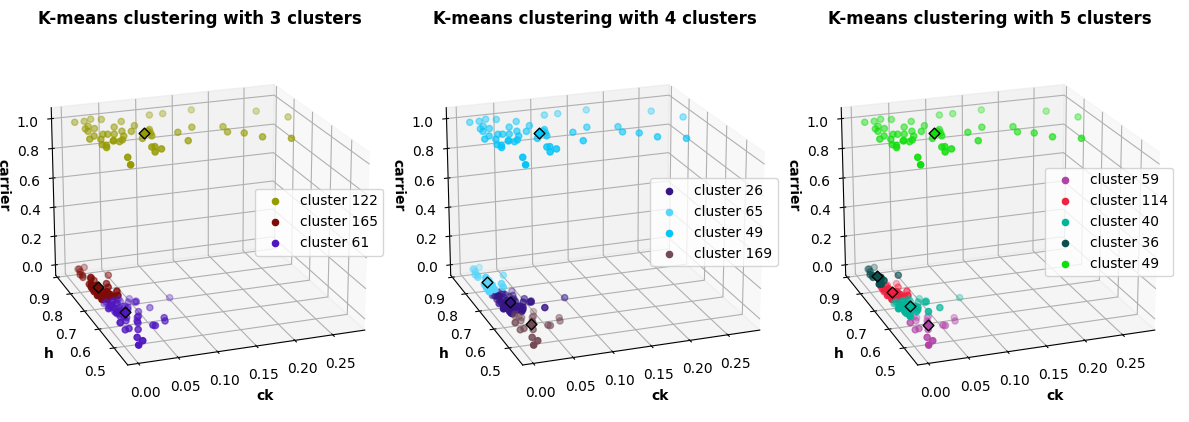

,Clusters N,Silhouette score
0,3.0,0.990716
1,4.0,0.990665
2,5.0,0.990740


In [32]:
kmeans_pipeline(data)